In [38]:
import pandas as pd
import pymc3 as pm
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import seaborn as sns

In [2]:
# Below function creates plots like 17.3 and 17.4.
f_dict = {'size':16}
color = '#add8e6'
def plot_grid(trace, burnin, data, sd_h, sd_w, mean_h, mean_w):
    plt.figure(figsize=(13,13))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])
        
    # Scatter plot observed data
    ax1.scatter(data.height, data.weight, s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=10)
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Convert parameters to original scale
    beta0 = trace['b_0'][burnin:]*sd_w+mean_w-trace['b_1'][burnin:]*mean_h*sd_w/sd_h
    beta1 = trace['b_1'][burnin:]*(sd_w/sd_h)
    sigma = trace['standard_deviation'][burnin:]*sd_w
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])
       
    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.as_matrix(), alpha=0.05), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(0, data.height.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax1.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    
        
    # Intercept
    pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
    ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)
    ax2.set_title('Intercept', fontdict={'weight':'bold'})

    # Slope
    pm.plot_posterior(beta1, point_estimate='mode', ax=ax3, color=color, ref_val=0)
    ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax3.set_title('Slope', fontdict={'weight':'bold'})
    
    # Scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor='none', alpha=.6)
    ax4.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax4.set_ylabel(r'$\beta_0$', fontdict=f_dict)
    
    # Scale
    pm.plot_posterior(sigma, point_estimate='mode', ax=ax5, color=color)
    ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)
    ax5.set_title('Scale', fontdict={'weight':'bold'})

    # Normality
    pm.plot_posterior(np.log10(trace['nu_minus_one'][burnin:] + 1), point_estimate='mode', ax=ax6, color=color)
    ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax6.set_title('Normality', fontdict={'weight':'bold'})
    
    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu_minus_one'][burnin:] + 1), sigma,
                edgecolor=color, facecolor='none', alpha=.6)
    ax7.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax7.set_ylabel(r'$\sigma$', fontdict=f_dict)
    
    plt.tight_layout()
    


# 17.2 Robust Linear Regression

In [ ]:
Image("images/fig17_2.png")

In [ ]:
df = pd.read_csv("data/HtWtData30.csv")
df.head()

In [ ]:
std_X = df["height"].std()
mean_X = df["height"].mean()
normalized_X = (df["height"] - mean_X) / std_X


std_Y = df["weight"].std()
mean_Y = df["weight"].mean()
normalized_Y = (df["weight"] - mean_Y) / std_Y

In [ ]:
data = df["weight"]
with pm.Model() as hw_30_model:
    b_0 = pm.Normal("b_0", mu=0, sd=10)
    b_1 = pm.Normal("b_1", mu=0, sd=10)
    
    mu = b_0 + b_1 * normalized_X.ravel()
    sd = pm.Uniform("standard_deviation", 0.001, 1000 )#try using data.std() * 10?
    nu_minus_one = pm.Exponential("nu_minus_one", 1/29)
    nu = nu_minus_one + 1
    obs = pm.StudentT("obs", nu=nu, mu=mu, sd=sd, observed=normalized_Y.ravel())
    
    trace = pm.sample(10000)

In [ ]:
pm.traceplot(trace[1000:])

In [ ]:
plot_grid(trace, 500, df, std_X, std_Y, mean_X, mean_Y)

In [ ]:
df_300 = pd.read_csv("data/HtWtData300.csv")
print(df_300.head())

std_X_300 = df_300["height"].std()
mean_X_300 = df_300["height"].mean()
normalized_X_300 = (df_300["height"] - mean_X_300) / std_X_300


std_Y_300 = df_300["weight"].std()
mean_Y_300 = df_300["weight"].mean()
normalized_Y_300 = (df_300["weight"] - mean_Y_300) / std_Y_300

In [ ]:
with pm.Model() as hw_300_model:
    b_0 = pm.Normal("b_0", mu=0, sd=10)
    b_1 = pm.Normal("b_1", mu=0, sd=10)
    
    mu = b_0 + b_1 * normalized_X_300.ravel()
    sd = pm.Uniform("standard_deviation", 0.001, 1000 )#try using data.std() * 10?
    nu_minus_one = pm.Exponential("nu_minus_one", 1/29)
    nu = nu_minus_one + 1
    obs = pm.StudentT("obs", nu=nu, mu=mu, sd=sd, observed=normalized_Y_300.ravel())
    
    trace_300 = pm.sample(10000)

In [ ]:
plot_grid(trace_300, 500, df_300, std_X_300, std_Y_300, mean_X_300, mean_Y_300)

# 17.3 Hierarchical Regression on Individuals Within Groups

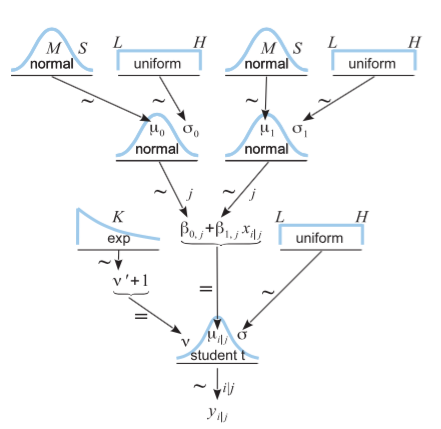

In [4]:
Image("images/fig17_6.png")

In [69]:
data = pd.read_csv("data/HierLinRegressData.csv")
data.Subj = data.Subj.astype('category')
data.sort_values(by=["Subj"], ascending=True, inplace=True)
data.Subj = data.Subj.cat.as_ordered()

In [70]:
category_codes = data.Subj.cat.codes.as_matrix()
std_X = data['X'].values.std()
std_Y = data['Y'].values.std()

mu_X = data['X'].values.mean()
mu_Y = data['Y'].values.mean()

z_X = (data['X'].values - mu_X ) / std_X
z_Y =  (data['Y'].values - mu_Y) / std_Y

/Users/jamesvanneman/anaconda2/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [72]:
subj_count = data["Subj"].value_counts().count()

In [61]:
with pm.Model() as income_fame_state_model:
    sd_beta_0 = pm.Uniform("zsd_beta_0", 10**-3, 10**3)
    sd_beta_1 = pm.Uniform("zsd_beta_1", 10**-3, 10**3)    
    
    mu_beta_0 = pm.Normal("zmu_beta_0", 0, 10)
    mu_beta_1 = pm.Normal("zmu_beta_1", 0, 10)
    beta_0 = pm.Normal("b_0", mu=mu_beta_0, sd=sd_beta_0, shape=subj_count)
    beta_1 = pm.Normal("b_1", mu=mu_beta_1, sd=sd_beta_1, shape=subj_count)
    mu = beta_0[category_codes] + beta_1[category_codes] * z_X
    
    nu_minus_one = pm.Exponential("nu_minus_one", 1/ 29)
    nu = nu_minus_one + 1
    sd = pm.Uniform("standard_deviation", 10**-3, 10**3)
    pm.StudentT("obs", nu=nu, mu=mu, sd=sd,  observed=z_Y)
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [standard_deviation, nu_minus_one, b_1, b_0, zmu_beta_1, zmu_beta_0, zsd_beta_1, zsd_beta_0]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:30<00:00, 232.91draws/s]
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b9080b8>,
      dtype=object)

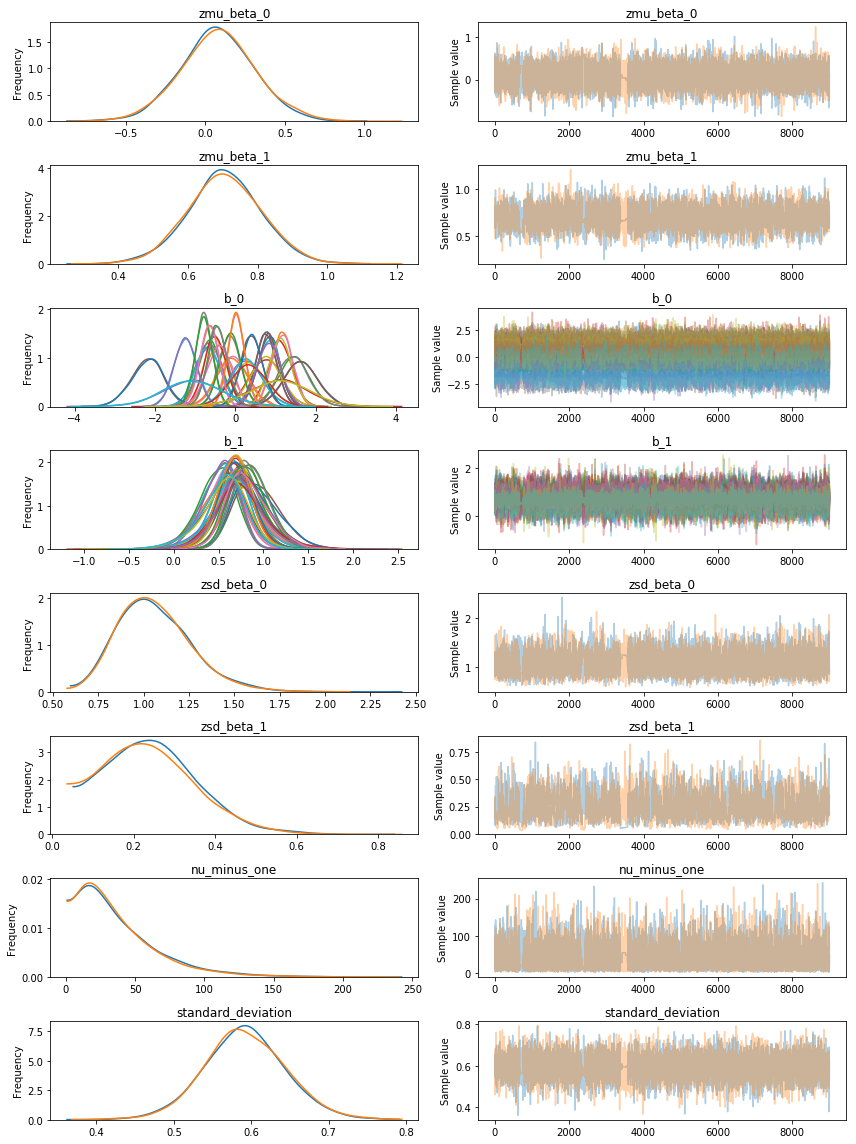

In [63]:
pm.plots.traceplot(trace[1000:])

In [64]:
def plot_cred_lines(dist, burnin, x, sd_x, sd_y, mean_x, mean_y, ax):
    # Convert parameters to original scale
    beta0 = dist[burnin:,0]*sd_y+mean_y-dist[burnin:,1]*mean_x*sd_y/sd_x
    beta1 = dist[burnin:,1]*(sd_y/sd_x)
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['zmu_beta_0', 'zmu_beta_1'])

    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.as_matrix(), alpha=0.05), decimals=3)
    hpd_interval = pm.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.zmu_beta_0.between(*hpd_interval[0,:]) & B.zmu_beta_1.between(*hpd_interval[1,:])] 
    xrange = np.arange(x.min()*.95, x.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)  

/Users/jamesvanneman/anaconda2/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/jamesvanneman/anaconda2/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


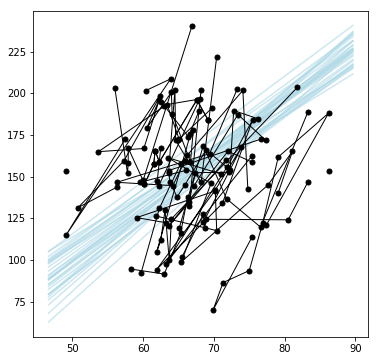

In [66]:
plt.figure(figsize=(6,6))
ax = plt.gca()
data.groupby("Subj").apply(lambda x: ax.plot(x.X, x.Y, 'k-o', lw=1, markersize=5) )
plot_cred_lines(np.c_[trace['zmu_beta_0'], trace['zmu_beta_1']], 1000, data.X, std_X, std_Y, mu_X, mu_Y, ax)

/Users/jamesvanneman/anaconda2/envs/py364/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/jamesvanneman/anaconda2/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/jamesvanneman/anaconda2/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


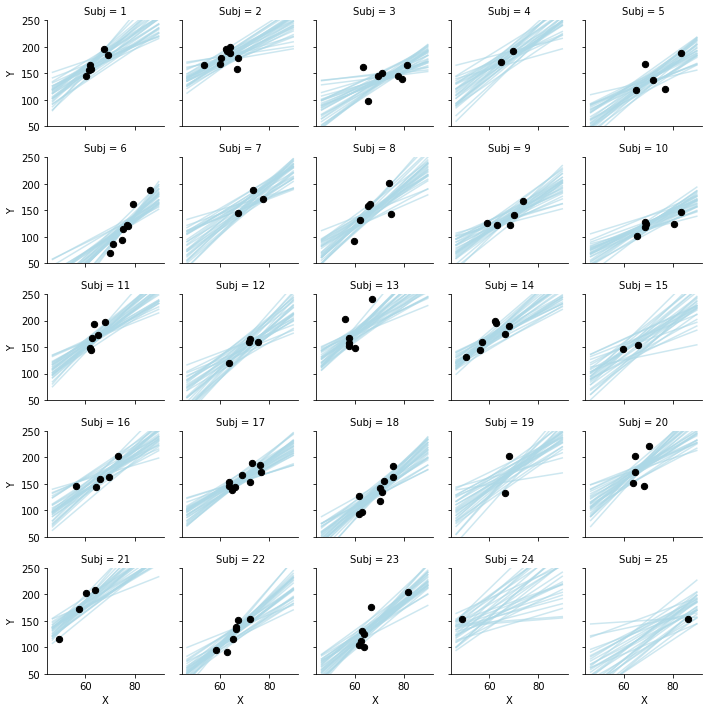

In [67]:
fg = sns.FacetGrid(data, col='Subj', col_wrap=5, ylim=(50,250), size=2)
fg.map(plt.scatter, 'X', 'Y', color='k', s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(np.c_[trace['b_0'][:,i], trace['b_1'][:,i]], 1000, data.X, std_X, std_Y, mu_X, mu_Y, ax)